# Improved SCA based on SVM
---

In AES encryption, the S-box (Substitution box) is the only non-linear operation in the algorithm.
It produces intermediate values that are directly related to the plaintext and the key. These intermediate values can be exploited to recover the key.

---

In this notebook we will train a model that to predict the Hamming weight of the intermediate value, targeting a specific byte of the encryption key.

---

#### 1. Importing training traces

In [1]:
import chipwhisperer as cw
import numpy as np

In [49]:
# To use the included Traces
# project_file = 'SCA_SVM_DATA/Included/traces/training_traces.cwp'

project_folder = 'SCA_SVM_DATA'    
traces_folder = f'{project_folder}/traces'
project_file = f'{traces_folder}/training_traces.cwp'

project = cw.open_project(project_file)
traces = np.array(project.waves)
textins = project.textins
key = project.keys[0]
hex_key = ''.join(f'{byte:02x}' for byte in key)
print(f"✅ Loaded {len(traces)} traces and textins with key {hex_key}")

✅ Loaded 20000 traces and textins with key 2b7e151628aed2a6abf7158809cf4f3c


**As we possess full knowledge of the training device, the S-box is included here to streamline the process.**

In [3]:
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

In [4]:
def hamming_weight(value):
    return bin(value).count('1')

#### 2. Feature Selection
To reduce the computational burden, we will identify the trace samples that have the strongest correlation with the relevant Hamming Weight.\
In other words, we'll select the samples that most effectively predict the outcome Hamming Weight.

In [48]:
byte_index = 0
print(f'We are training a model targeting byte {byte_index}')

We are training a model targeting byte 0


Calculate the intermediate values and their Hamming Weight

In [42]:
c = []
for i in range(len(textins)):
    sbox_in = textins[i][byte_index] ^ key[byte_index]
    sbox_out = SBOX[sbox_in]
    hw = hamming_weight(sbox_out)
    c.append(hw)

Finding the strongest correlated samples

In [43]:
from scipy.stats import pearsonr

t = traces.T
p = []
for i in range(len(t)):
    p.append(abs(pearsonr(t[i],c)[0]))
p = np.array(p)
p_sorted_indices = np.argsort(p)[::-1]

Let's visualize it:

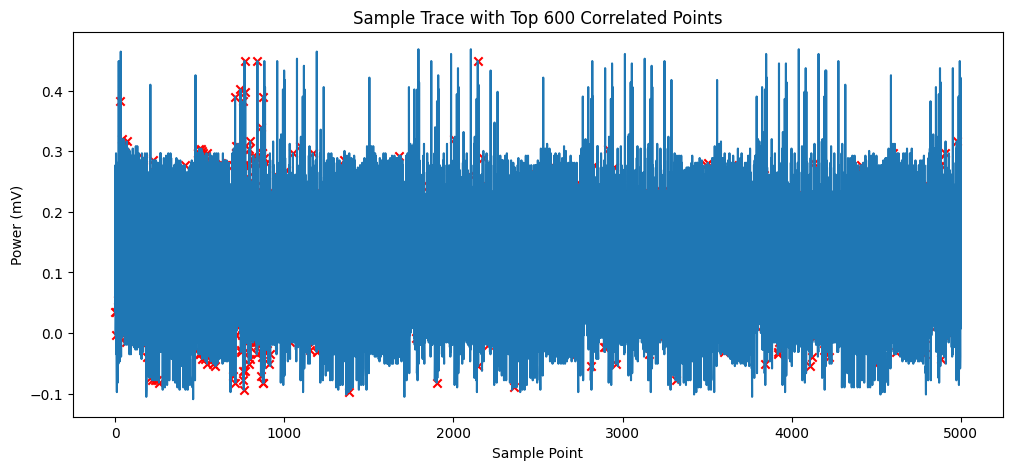

In [51]:
# Plot a sample power trace with the first 600 selected feature points marked in red.
plt.figure(figsize=(12, 5))
plt.plot(traces[0])
plt.scatter(p_sorted_indices[:600], traces[0, p_sorted_indices[:600]], color='red', marker='x')
plt.title("Sample Trace with Top 600 Correlated Points")
plt.xlabel("Sample Point")
plt.ylabel("Power (mV)")
plt.show()

#### 3. Training the model

In [13]:
from sklearn.feature_selection import f_regression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [23]:
import matplotlib.pyplot as plt

def print_summary(y_test, y_pred):
    print(classification_report(y_test, y_pred, zero_division=1))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(10, 8))
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

In [37]:
def prepare_X_y(t, p, c, M, N):
    X = t[np.sort(p[:N])][:,:M].T
    X_train, X_test, y_train, y_test = train_test_split(X, c[:M], test_size = 0.2, random_state=5)
    print(f"Training set: {X_train.shape[0]} traces with {X_train.shape[1]} features")
    print(f"Test set: {X_test.shape[0]} traces")
    return X_train, X_test, y_train, y_test

In [25]:
def optimize_and_train_model(t, p, M_values, N_values, c):
    best_model = {}
    best_score = 0
    
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 2],
        'kernel': ['rbf', 'linear', 'polynomial', 'sigmoid']
    }
    
    for M in M_values:
        for N in N_values:
            X_train, X_test, y_train, y_test = prepare_X_y(t, p, c, M, N)
            
            # Perform grid search
            svm = SVC(decision_function_shape='ovo')
            grid_search = GridSearchCV(svm, param_grid, cv=2, n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            
            model = grid_search.best_estimator_
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            
            # Save the best estimator
            if score > best_score:
                best_model = {'model': model, 'M': M, 'N': N, 'params': grid_search.best_params_, 'score': score}
                
    # Print result
    print(f"Best estimator with M={best_model['M']}, N={best_model['N']}, Params:{best_model['params']}")
    print_summary(y_test, y_pred)
    
    return best_model

In [38]:
def train_model(t, p, c, M, N, C, gamma, kernel):
    X_train, X_test, y_train, y_test = prepare_X_y(t, p, c, M, N)
    
    model = SVC(C=C, gamma = gamma, kernel=kernel, decision_function_shape='ovo')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print_summary(y_test, y_pred)
    
    return model

In [40]:
M_values = [x for x in range(2000, 20001, 2000)]
N_values = [x for x in range(50, 601, 50)]

Training set: 14400 traces with 500 features
Test set: 3600 traces
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.96      0.94      0.95        95
           2       0.97      0.97      0.97       390
           3       0.97      0.97      0.97       776
           4       0.97      0.97      0.97       994
           5       0.97      0.97      0.97       793
           6       0.96      0.95      0.96       385
           7       0.93      0.96      0.94       130
           8       1.00      0.57      0.73        21

    accuracy                           0.97      3600
   macro avg       0.96      0.92      0.93      3600
weighted avg       0.97      0.97      0.97      3600



<Figure size 1000x800 with 0 Axes>

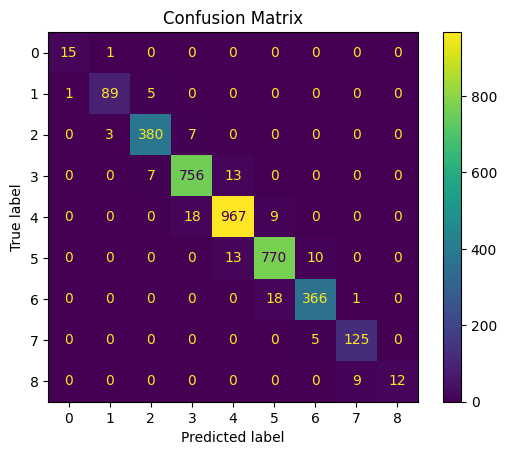

In [44]:
model_data = optimize_and_train_model(t, p_sorted_indices, M_values, N_values, c)
model = model_data['model']

#### 4. Saving the model

In [46]:
import joblib
import os

models_folder = f'{project_folder}/models'
os.makedirs(models_folder, exist_ok = True)

model_file = f'{models_folder}/hw_model.pkl'
model_data = {
    'model': model,
    'p': p_sorted_indices[:model_data['N']]
}

joblib.dump(model_data, model_file)
print(f"Model saved to {model_file}")

Model saved to SCA_SVM_DATA/models/hw_model.pkl


### That's it for training! Let's execute the attack😈